<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try: 
  COLAB = True
  import tensorflow as tf
  print(f"You are on colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n....please load your drive....")
def time_fmt(x:float)->float:
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"

print(f"...testing...: {time_fmt(123.87756)}")

Mounted at /content/drive
You are on colab with tensorflow version: 2.4.1
...testing...: 0: 002: 03.00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
pd.set_option('max_rows', 6)
pd.set_option('max_columns', 0)
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
#Consider the following data recorded on individuals of a particular area. If we want to predict let say (income) based on 
#various factors as given in the data we can train a simple mlp. We first investigate some patterns in this data

In [ ]:
data = pd.read_csv("https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv", na_values = ['NA', '?'])

In [ ]:
data.isna().value_counts() #income has some missing values:

id     job    area   income  aspect  subscriptions  dist_healthy  save_rate  dist_unhealthy  age    pop_dense  retail_dense  crime  product
False  False  False  False   False   False          False         False      False           False  False      False         False  False      1941
                     True    False   False          False         False      False           False  False      False         False  False        59
dtype: int64

In [ ]:
#we compute the missing value for the income using the median income:(mean is not suitable due to sensitivity to extremities)
data['income'] = data['income'].fillna(data['income'].median())

In [ ]:
display(data['income'].isna().value_counts()) #check if the work is done

False    2000
Name: income, dtype: int64

In [ ]:
display(data)

,id,job,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,1,vv,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,2,kd,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,3,pe,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,1998,kl,d,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703,f
1998,1999,qp,c,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803,c
1999,2000,pe,c,61467.0,16.891667,0,4.312097,8,9.405648,48,0.925197,0.539370,0.451973,c


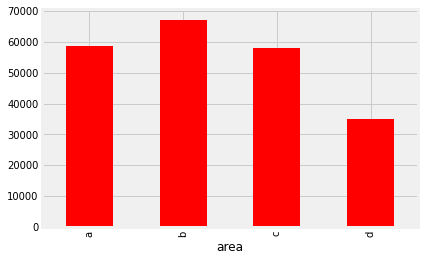

In [ ]:
#Check if the area has any impact on average income:
data.groupby('area').income.mean().plot(kind = 'bar', color = 'red')

In [ ]:
#We can also check if amount of encome earned on average has any thing to do with product purchased:

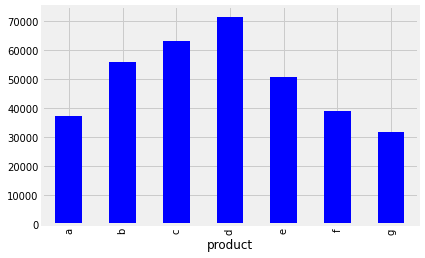

In [ ]:
data.groupby('product').income.mean().plot(kind = 'bar', color = 'blue')

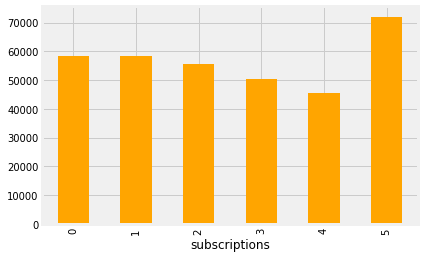

In [ ]:
#We can also see if subscription type depends on average income of a person:
data.groupby('subscriptions').income.mean().plot(kind = 'bar', color = 'orange')

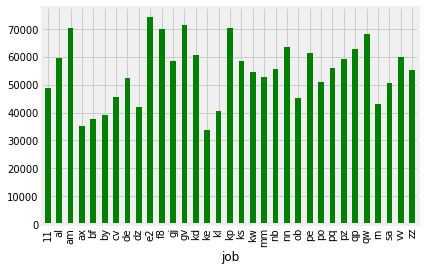

In [ ]:
#Check the connection between average income and job type:
data.groupby('job').income.mean().plot(kind = 'bar', color = 'green')

In [ ]:
#We can draw some useful comments based on plotting like the above ones:

In [ ]:
#Prepare the data for training:
#We first convert all categorical variables to dummy variables:
area_d = pd.get_dummies(data['area'], prefix = 'area')
subscriptions_d = pd.get_dummies(data['subscriptions'], prefix = 'subscription')
product_d = pd.get_dummies(data['product'], prefix = 'product')
job_cat = pd.get_dummies(data['job'], prefix = 'job')

In [ ]:
#We standardize all continous features to get uniform scale by computing their z-scores:

In [ ]:
data = data.drop(['job', 'id','area', 'subscriptions','product'], axis = 1)

In [ ]:
display(data)

,income,aspect,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime
0,50876.0,13.100000,9.017895,35,11.738935,49,0.885827,0.492126,0.071100
1,60369.0,18.625000,7.766643,59,6.805396,51,0.874016,0.342520,0.400809
2,55126.0,34.766667,3.632069,6,13.671772,44,0.944882,0.724409,0.207723
...,...,...,...,...,...,...,...,...,...
1997,28595.0,39.425000,7.168218,99,4.626950,36,0.759843,0.744094,0.098703
1998,67949.0,5.733333,8.936292,26,3.281439,46,0.909449,0.598425,0.117803
1999,61467.0,16.891667,4.312097,8,9.405648,48,0.925197,0.539370,0.451973


In [ ]:
cols = data.columns

In [ ]:
from scipy.stats import zscore

In [ ]:
for col in cols:
  data[col] = zscore(data[col])

In [ ]:
display(data)

,income,aspect,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime
0,-0.607550,-0.664918,-0.048411,-0.215764,-0.314089,0.854321,0.079279,-0.465765,-1.120315
1,0.338053,-0.207748,-0.266765,0.196869,-0.915161,1.394432,-0.075010,-1.445372,0.682945
2,-0.184205,1.127906,-0.988286,-0.714362,-0.078604,-0.495957,0.850727,1.055205,-0.373087
...,...,...,...,...,...,...,...,...,...
1997,-2.826971,1.513363,-0.371196,0.884591,-1.180569,-2.656402,-1.566477,1.184101,-0.969344
1998,1.093101,-1.274478,-0.062651,-0.370502,-1.344498,0.044154,0.387858,0.230272,-0.864885
1999,0.447425,-0.351174,-0.869615,-0.679976,-0.598362,0.584265,0.593578,-0.156415,0.962774


In [ ]:
target = data['income'].values

In [ ]:
data.drop('income', axis = 1, inplace = True)

In [ ]:
data = pd.concat([data, area_d, job_cat,product_d, subscriptions_d], axis = 1)

In [ ]:
display(data)

,aspect,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,area_a,area_b,area_c,area_d,job_11,job_al,job_am,job_ax,job_bf,job_by,job_cv,job_de,job_dz,job_e2,job_f8,job_gj,job_gv,job_kd,job_ke,job_kl,job_kp,job_ks,job_kw,job_mm,job_nb,job_nn,job_ob,job_pe,job_po,job_pq,job_pz,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz,product_a,product_b,product_c,product_d,product_e,product_f,product_g,subscription_0,subscription_1,subscription_2,subscription_3,subscription_4,subscription_5
0,-0.664918,-0.048411,-0.215764,-0.314089,0.854321,0.079279,-0.465765,-1.120315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,-0.207748,-0.266765,0.196869,-0.915161,1.394432,-0.075010,-1.445372,0.682945,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,1.127906,-0.988286,-0.714362,-0.078604,-0.495957,0.850727,1.055205,-0.373087,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,1.513363,-0.371196,0.884591,-1.180569,-2.656402,-1.566477,1.184101,-0.969344,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1998,-1.274478,-0.062651,-0.370502,-1.344498,0.044154,0.387858,0.230272,-0.864885,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1999,-0.351174,-0.869615,-0.679976,-0.598362,0.584265,0.593578,-0.156415,0.962774,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [ ]:
x = data.values

In [ ]:
print(f"x_shape: {x.shape}, target_shape: {target.shape}")

x_shape: (2000, 58), target_shape: (2000,)


In [ ]:
#Split the data into training-validation sets:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, target, test_size = 0.2)

In [ ]:
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

x_train_shape: (1600, 58), y_train_shape: (1600,)
x_test_shape: (400, 58), y_test_shape: (400,)


In [ ]:
#Convert into tensorflow datatype:
BUFFER = 1024
BATCH_SIZE = 16
EPOCHS = 30
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(BUFFER).batch(batch_size = BATCH_SIZE, drop_remainder = True)
validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_data = validation_data.shuffle(BUFFER).batch(batch_size = BATCH_SIZE, drop_remainder = True)
x_train_batch_sample, y_train_batch_sample = next(iter(train_data))
print(f"x_batch_sample_shape: {x_train_batch_sample.shape}\ny_batch_sample_shape: {y_train_batch_sample.shape}")

x_batch_sample_shape: (16, 58)
y_batch_sample_shape: (16,)


In [ ]:
#We now build our MLP with few layers to train a model that predict income of an individual
#based on the derived features above:

Model: "mlp_income"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dim (InputLayer)       [(None, 58)]              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               7552      
_________________________________________________________________
dense2 (Dense)               (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 15,873
Trainable params: 15,873
Non-trainable params: 0
_________________________________________________________________


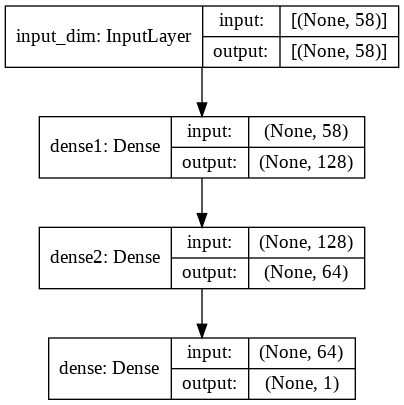

In [ ]:
inputs = tf.keras.Input(shape = (58,), name = 'input_dim')
x = tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu',name = 'dense1')(inputs)
x = tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense2')(x)
outputs = tf.keras.layers.Dense(units = 1)(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_income')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'mlp_income.png', show_shapes = True)

In [ ]:
#We can now compile and training our model as follows:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-3),
              loss = tf.keras.losses.MeanSquaredError())

In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 2, epochs = EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
100/100 - 1s - loss: 0.3873 - val_loss: 0.2319
Epoch 2/30
100/100 - 0s - loss: 0.1931 - val_loss: 0.2125
Epoch 3/30
100/100 - 0s - loss: 0.1672 - val_loss: 0.2029
Epoch 4/30
100/100 - 0s - loss: 0.1571 - val_loss: 0.2031
Epoch 5/30
100/100 - 0s - loss: 0.1498 - val_loss: 0.1951
Epoch 6/30
100/100 - 0s - loss: 0.1399 - val_loss: 0.2261
Epoch 7/30
100/100 - 0s - loss: 0.1377 - val_loss: 0.2026
Epoch 8/30
100/100 - 0s - loss: 0.1304 - val_loss: 0.1934
Epoch 9/30
100/100 - 0s - loss: 0.1268 - val_loss: 0.1909
Epoch 10/30
100/100 - 0s - loss: 0.1197 - val_loss: 0.2061
Epoch 11/30
100/100 - 0s - loss: 0.1194 - val_loss: 0.2015
Epoch 12/30
100/100 - 0s - loss: 0.1139 - val_loss: 0.2132
Epoch 13/30
100/100 - 0s - loss: 0.1121 - val_loss: 0.1918
Epoch 14/30
100/100 - 0s - loss: 0.1061 - val_loss: 0.2046
Epoch 15/30
100/100 - 0s - loss: 0.1077 - val_loss: 0.1945
Epoch 16/30
100/100 - 0s - loss: 0.1044 - val_loss: 0.2019
Epoch 17/30
100/100 - 0s - loss: 0.1004 - val_loss: 0.1941
Epoch 

In [ ]:
preds = model.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
se = np.sqrt(mean_squared_error(preds, y_test))

In [ ]:
print(f"The standard error for the prediction is : {se:.4f}")

The standard error for the prediction is : 0.4664


In [ ]:
#We can plot the lift chart to see how well our predictions are close to reality:

In [ ]:
def lift_plot(pred, y, sort = True):
  data = pd.DataFrame({'y': y.flatten(), 'pred': pred})
  if sort:
    data.sort_values(by = ['y'], inplace = True)
  plt.plot(data['y'].to_list(), label = 'true value')
  plt.plot(data['pred'].to_list(), label = 'predictions')
  plt.ylabel('output')
  plt.title('The lift chart')
  plt.legend()
  plt.show()


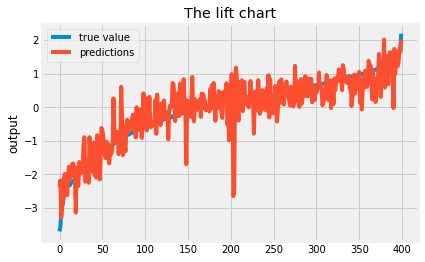

In [ ]:
lift_plot(preds.flatten(), y_test)

In [ ]:
#We can see from the plot that our prediction and true values for income 
#fits well arround midd-range and slight variations at the starting and ending